# 0.0 IMPORTS

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from tabulate              import tabulate
from scipy.stats           import chi2_contingency

## 0.1 Helper Function

In [352]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [68]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [119]:
aep = pd.read_csv( 'data/AEP_hourly.csv', low_memory=False )
comed = pd.read_csv( 'data/COMED_hourly.csv', low_memory=False )
dayton = pd.read_csv( 'data/DAYTON_hourly.csv', low_memory=False )
deok = pd.read_csv( 'data/DEOK_hourly.csv', low_memory=False )
dom = pd.read_csv( 'data/DOM_hourly.csv', low_memory=False )
duq = pd.read_csv( 'data/DUQ_hourly.csv', low_memory=False )
ekpc = pd.read_csv( 'data/EKPC_hourly.csv', low_memory=False )
fe = pd.read_csv( 'data/FE_hourly.csv', low_memory=False )
ni = pd.read_csv( 'data/NI_hourly.csv', low_memory=False )
pjm = pd.read_csv( 'data/PJM_Load_hourly.csv', low_memory=False )
pjme = pd.read_csv( 'data/PJME_hourly.csv', low_memory=False )
pjmw = pd.read_csv( 'data/PJMW_hourly.csv', low_memory=False )

In [120]:
# I will combine all the datasets into one. For this I will create a column in each of the datasets that will identify your respective electric company.

aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

In [121]:
# the column in each dataset that shows the Megawatt Energy Consumption, I will rename it with the same name in all.

aep = aep.rename( columns={'AEP_MW': 'mw_energy_consumption'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy_consumption'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy_consumption'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy_consumption'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy_consumption'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy_consumption'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy_consumption'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy_consumption'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy_consumption'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy_consumption'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy_consumption'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy_consumption'} )

In [124]:
# Concatenate all the datasets
df_raw = pd.concat( [aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm, pjme, pjmw] )
df_raw.sample(5) # check

,Datetime,mw_energy_consumption,electric_company
77604,2013-05-25 09:00:00,12329.0,AEP
140369,2018-07-28 19:00:00,42174.0,PJME
120607,2018-01-28 05:00:00,1635.0,DAYTON
27429,2014-06-16 02:00:00,6428.0,FE
22043,2015-01-26 13:00:00,2016.0,EKPC


In [125]:
df_raw.shape

(1090167, 3)

# 1.0 STEP 01 - DESCRIPTION OF DATA

In [126]:
# At the beginning of each step I will make a copy of the dataset to make it easier to reload the data in case there is a problem with the project.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [127]:
# Although I already renamed some columns when I was preparing the datasets to concatenate them, I will check if there are any more columns that are not in the format I want them to be.
df1.columns

Index(['Datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

In [128]:
# Only the column "Datetime" don't have the format that I want.
cols_old = ['Datetime', 'mw_energy_consumption', 'electric_company']

# If the dataset had too many columns to change I would use the "snakecase" technique through the "inflection" function. Since this dataset has only one column to change the name, I will do this process manually.
cols_new = ['datetime', 'mw_energy_consumption', 'electric_company']

# rename
df1.columns = cols_new

In [129]:
df1.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

## 1.2 Data Dimensions

In [130]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 1090167
Number of Cols: 3


## 1.3 Data Types

In [131]:
df1.dtypes
# Observe datetime. It has a different data type.

datetime                  object
mw_energy_consumption    float64
electric_company          object
dtype: object

In [132]:
# function "datetime" transforma the columns "datetime" from object (string) to datetime.
df1['datetime'] = pd.to_datetime( df1['datetime'] )

In [133]:
df1.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
dtype: object

## 1.4 Check NA

In [134]:
df1.isna().sum()

datetime                 0
mw_energy_consumption    0
electric_company         0
dtype: int64

## 1.5 Fillout NA

In [135]:
# We don't have NA value to fillout... :)

## 1.6 Change Types

In [136]:
# We already did the change types.

## 1.7 Descriptive Statistical

In [137]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = df1.select_dtypes( include=['float64'] )
cat_attributes = df1.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [139]:
num_attributes.sample()

,mw_energy_consumption
4028,39569.0


In [140]:
cat_attributes.sample()

,electric_company
54163,FE


### 1.7.1 Numerical Attibutes

In [141]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [142]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,mw_energy_consumption,0.0,62009.0,62009.0,11209.58865,8217.0,10534.394704,1.356423,1.198281


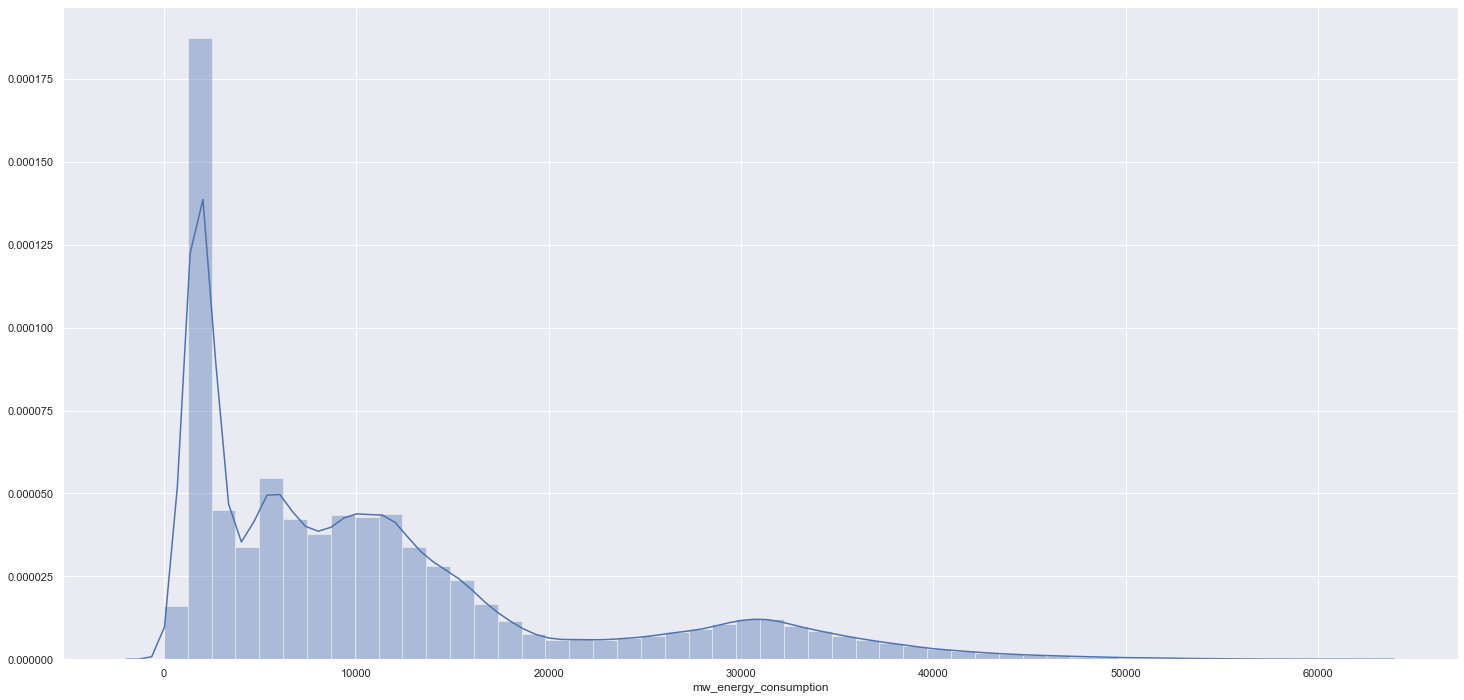

In [143]:
sns.distplot( df1['mw_energy_consumption'] )

### 1.7.2 Cetegorical Attibutes

In [145]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

electric_company    12
dtype: int64

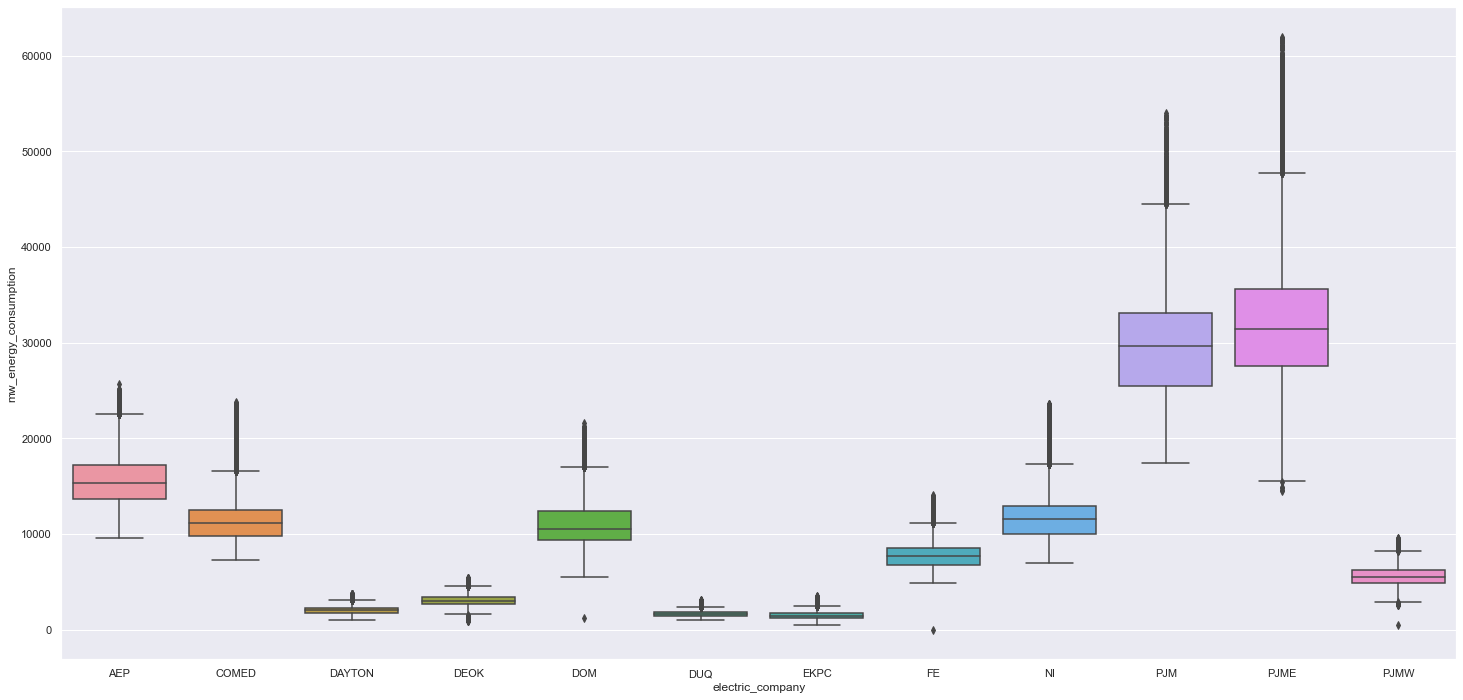

In [146]:
sns.boxplot( x= 'electric_company', y='mw_energy_consumption' , data=df1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [323]:
df2 = df1.copy()

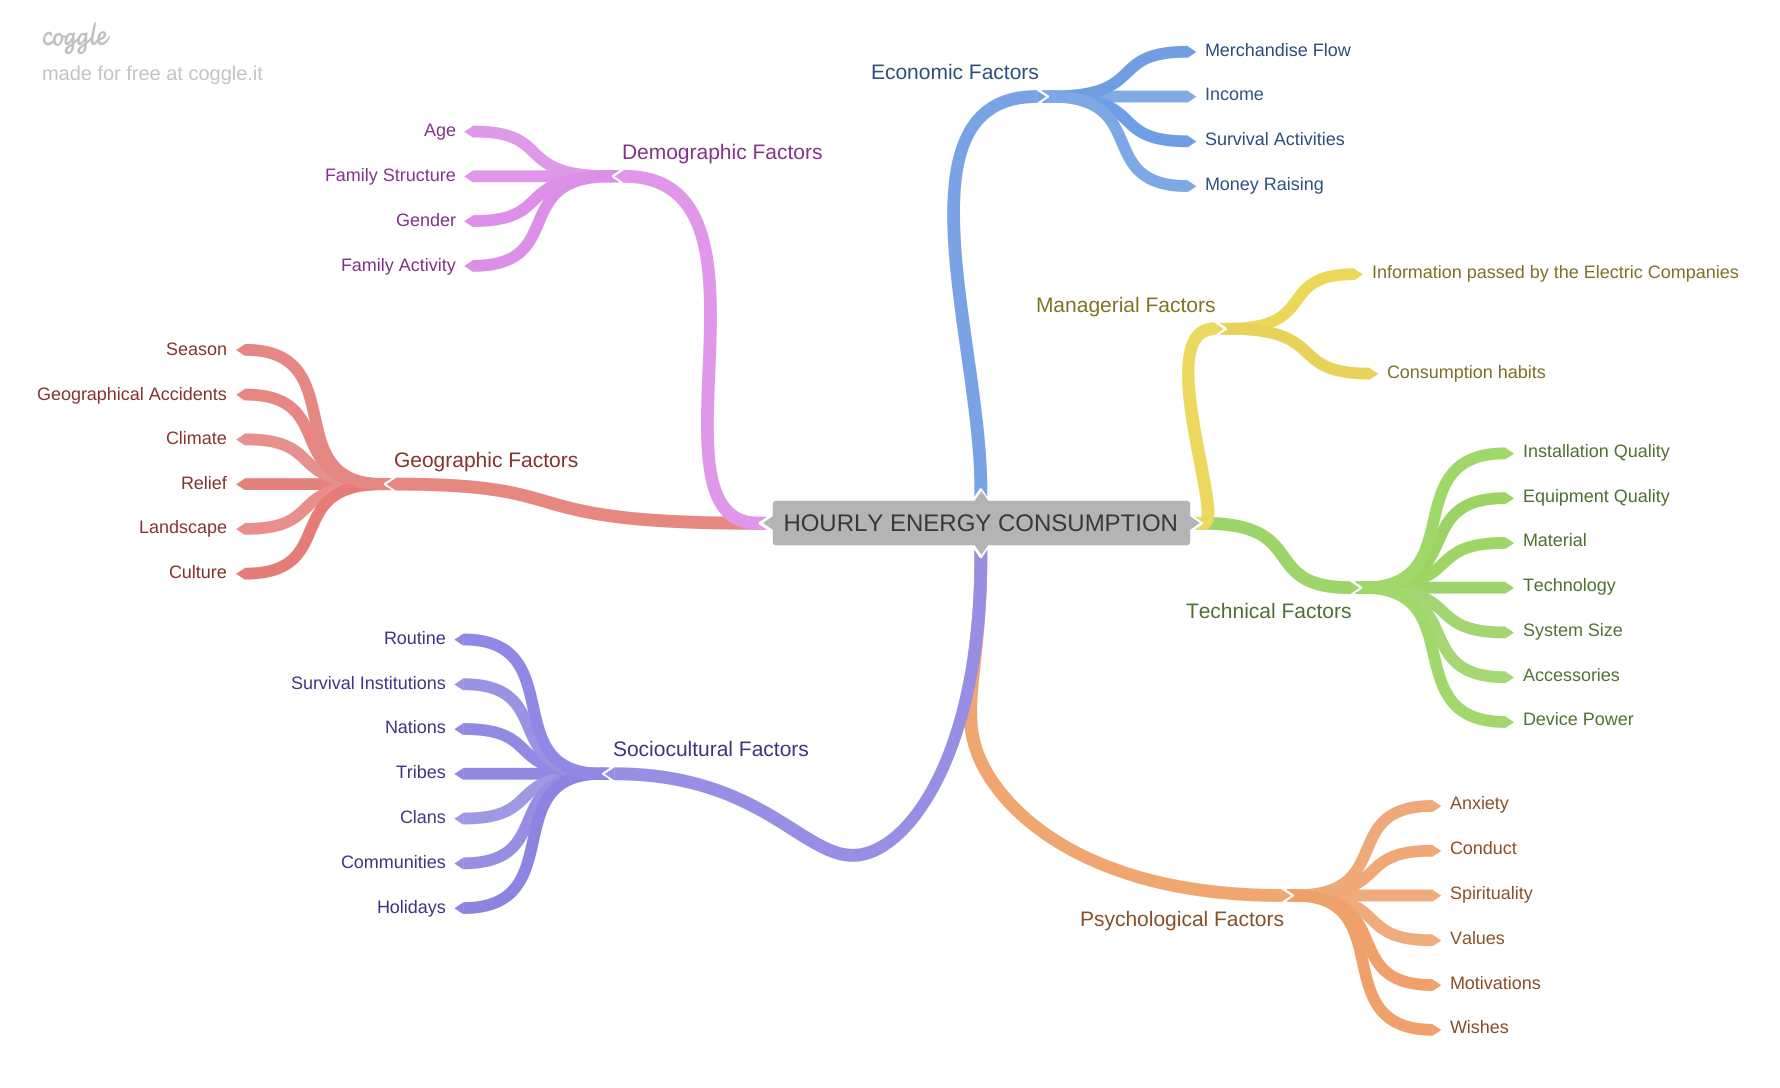

In [296]:
Image( 'image/Hyphoteses_Map.png' )
# As we can see in the Hypothesis Map below, there are many factors that influence the consumption of electricity and that we could use to try to predict them.
# The point is that we only have "datetime" information in the dataset. Because of this we will only use a few elements and their attributes.

## 2.1 Creation of Hypotheses

### 2.1.1 Demographic Hypotheses

**1.** Older people spend less energy

**2.** Larger families spend more energy

**3.** Female people spend more energy

**4.** Family activity influences energy expenditure in the early morning and late afternoon.

### 2.1.2 Geographic Hypotheses

**1.** Seasons with higher temperatures use more energy

**2.** Locations present in geographic accidents spend more energy

**3.** Climate with higher temperatures use more energy

### 2.1.3 Sociocultural Hypotheses

**1.** Routines that start when there is less sunlight use more energy

**2.** Tribes spend less energy

**3.** Nations spend more energy

**4.** Communities spend less energy

**5.** Holiday periods spend more energy

## 2.2 Final List of Hypotheses

**1.** Family activity influences energy expenditure in the early morning and late afternoon only

**2.** Seasons with higher or lower temperatures use more energy

**3.** Holiday periods spend more energy

**4.** Weekends periods spend more energy

## 2.3 Feature Engineering

In [324]:
## date
# I want to have a view of the evolution of energy consumption by looking only at the dates as information, excluding an hour when they were recorded.

df2['date'] = df2['datetime'].dt.date

## year
# I will not directly validate any hypothesis with the date "year", but I will use this information to better visualize some variables in the validation process within the EDA.

df2['year'] = df2['datetime'].dt.year

## month
# I will not directly validate any hypothesis with the date "month", but I will use this information to better visualize some variables in the validation process within the EDA.

df2['month'] = df2['datetime'].dt.month

## hour_of_day:

# Initially I thought about converting the hours in the "datetime" column to float, because it would be better to visualize the energy consumption by the evolution of the hours, but observing the part of the hours in the "datetime" column we can see that all of them have only the same hour and not the minute and second. For this reason I will only create the "hour_of_day" column using the "hour" function.

df2['hour_of_day'] = df2['datetime'].dt.hour

# season:

# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).

df2['season'] = df2['datetime'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

## holiday:

# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this librarie is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".

df2['holidays'] = df2['datetime'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

## day_of_week:

# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday

df2['day_of_week'] = df2['datetime'].dt.weekday

In [325]:
# Recheck data types after feature engineering
df2.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
date                             object
year                              int64
month                             int64
hour_of_day                       int64
season                           object
holidays                         object
day_of_week                       int64
dtype: object

In [326]:
# The column "date" is a datetime type columns, but it is like a object type column. I will change the type.
df2['date'] = pd.to_datetime( df2['date'] )

In [327]:
df2.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
date                     datetime64[ns]
year                              int64
month                             int64
hour_of_day                       int64
season                           object
holidays                         object
day_of_week                       int64
dtype: object

In [328]:
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [329]:
df2.sample(10).T

,74461,19913,22902,78115,115623,15582,34703,53281,111137,77072
datetime,2013-10-03 09:00:00,2013-04-26 22:00:00,2007-01-21 12:00:00,2013-05-04 15:00:00,2017-01-22 12:00:00,2006-06-22 11:00:00,2017-08-19 00:00:00,2010-03-04 16:00:00,2017-04-27 12:00:00,2014-11-16 03:00:00
mw_energy_consumption,2099,7420,13111,1591,1669,3004,1411,16319,1667,10584
electric_company,DAYTON,FE,DOM,DAYTON,DAYTON,DAYTON,EKPC,AEP,DUQ,DOM
date,2013-10-03 00:00:00,2013-04-26 00:00:00,2007-01-21 00:00:00,2013-05-04 00:00:00,2017-01-22 00:00:00,2006-06-22 00:00:00,2017-08-19 00:00:00,2010-03-04 00:00:00,2017-04-27 00:00:00,2014-11-16 00:00:00
year,2013,2013,2007,2013,2017,2006,2017,2010,2017,2014
month,10,4,1,5,1,6,8,3,4,11
hour_of_day,9,22,12,15,12,11,0,16,12,3
season,Autumn,Spring,Winter,Spring,Winter,Summer,Summer,Spring,Spring,Autumn
holidays,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day
day_of_week,3,4,6,5,6,3,5,3,3,6


# 3.0 STEP 03 - VARIABLE FILTERING

In [330]:
df3 = df2.copy()

In [331]:
df3.head()

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,holidays,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,Holiday,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,Holiday,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,Holiday,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,Holiday,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,Holiday,4


## 3.1 Line Filtering

In [332]:
# There isn't any line filtering to do in this project

## 3.2 Column Selection

In [333]:
# There isn't any column selection to do in this project

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [334]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

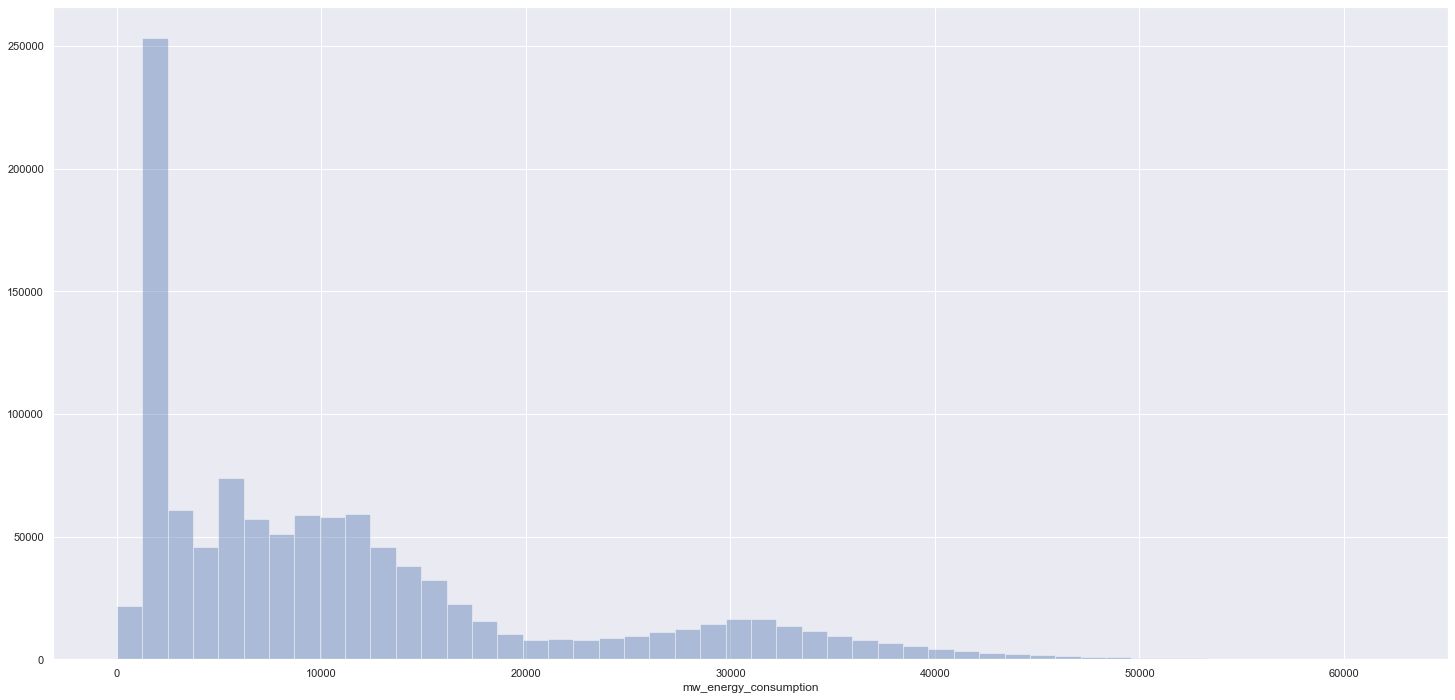

In [335]:
sns.distplot( df4['mw_energy_consumption'], kde=False )

### 4.1.2 Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021B12090888>,
      dtype=object)

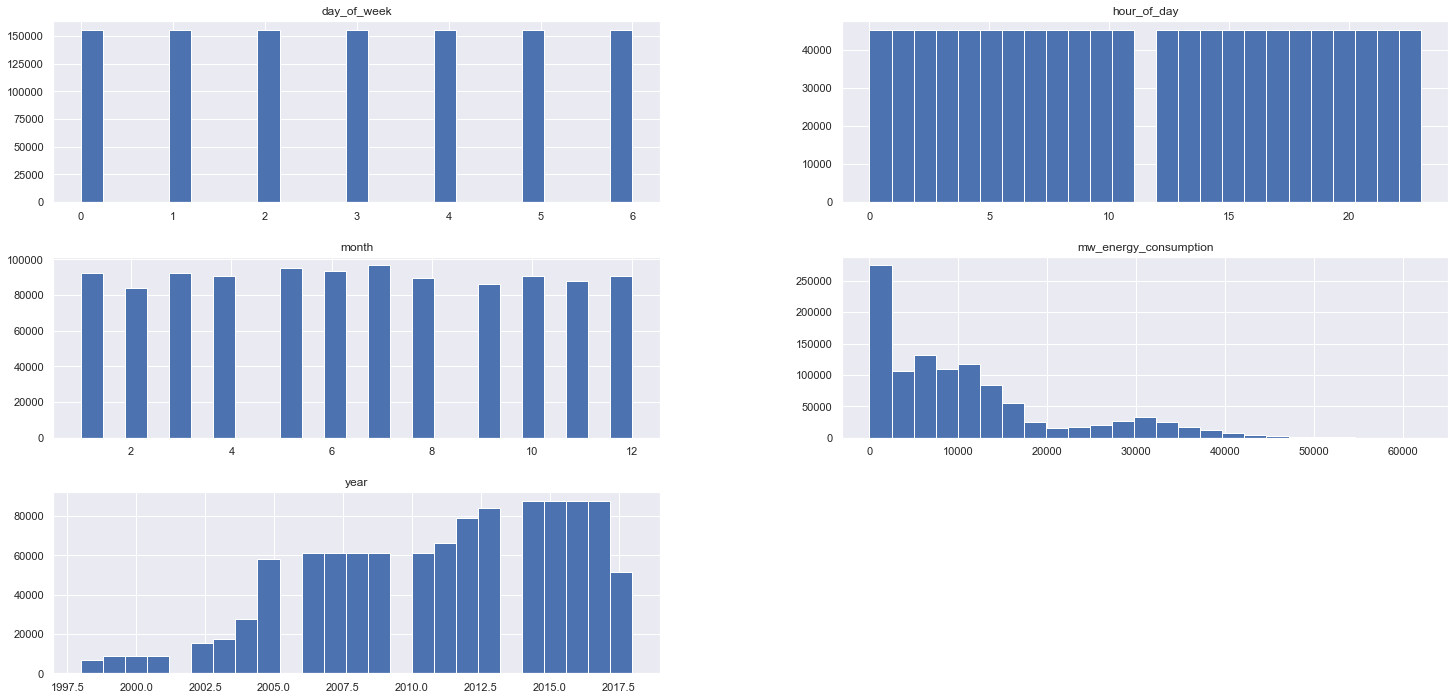

In [336]:
num_attributes.hist( bins=25 )

### 4.1.3 Categorical Variable

In [337]:
cat_attributes.head()

,electric_company,season,holidays
0,AEP,Winter,Holiday
1,AEP,Winter,Holiday
2,AEP,Winter,Holiday
3,AEP,Winter,Holiday
4,AEP,Winter,Holiday


In [338]:
df4['electric_company'].drop_duplicates()

0       AEP
0     COMED
0    DAYTON
0      DEOK
0       DOM
0       DUQ
0      EKPC
0        FE
0        NI
0       PJM
0      PJME
0      PJMW
Name: electric_company, dtype: object

In [339]:
df4['season'].drop_duplicates()

0       Winter
744     Autumn
5134    Summer
7342    Spring
Name: season, dtype: object

In [340]:
df4['holidays'].drop_duplicates()

0        Holiday
48    Normal day
Name: holidays, dtype: object

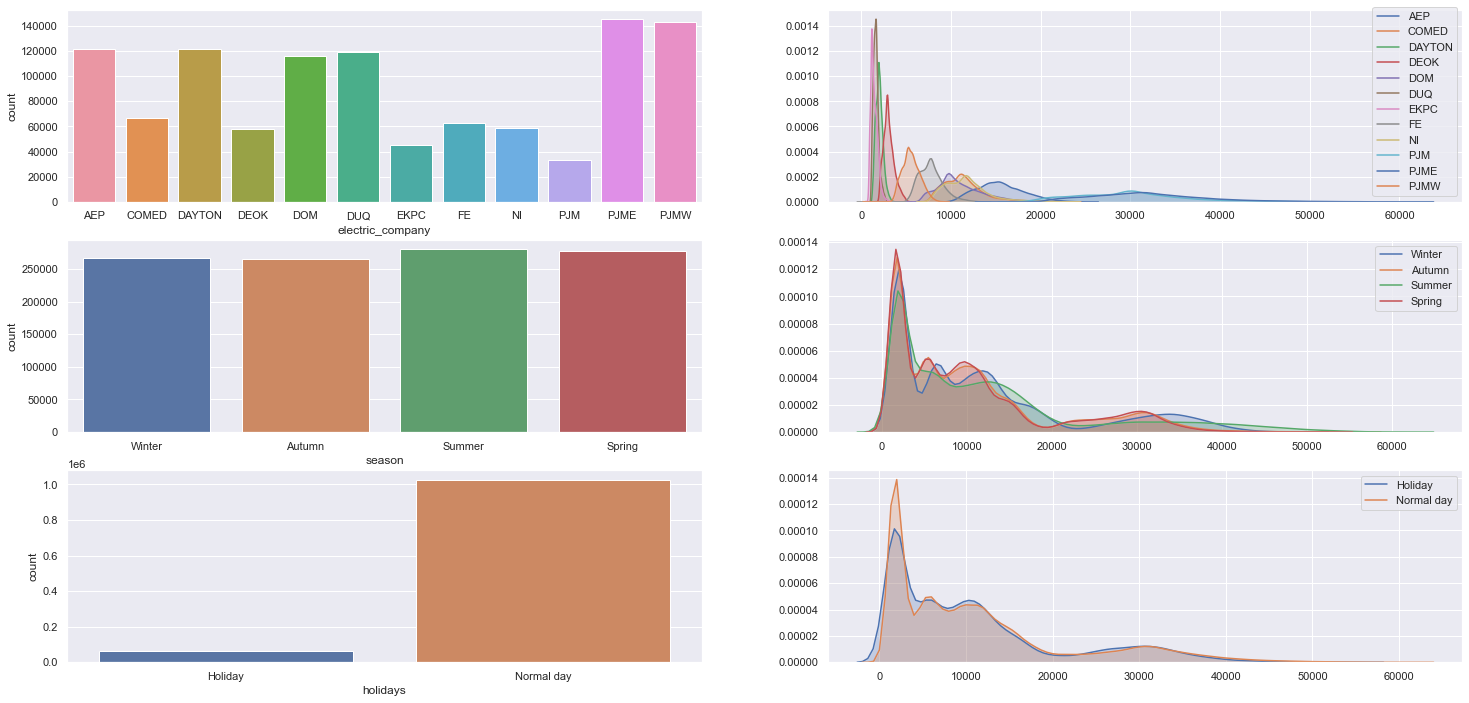

In [341]:
# electric_company

plt.subplot( 3, 2, 1)
sns.countplot( df4['electric_company'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['electric_company'] == 'AEP']['mw_energy_consumption'], label='AEP', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'COMED']['mw_energy_consumption'], label='COMED', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DAYTON']['mw_energy_consumption'], label='DAYTON', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DEOK']['mw_energy_consumption'], label='DEOK', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DOM']['mw_energy_consumption'], label='DOM', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DUQ']['mw_energy_consumption'], label='DUQ', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'EKPC']['mw_energy_consumption'], label='EKPC', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'FE']['mw_energy_consumption'], label='FE', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'NI']['mw_energy_consumption'], label='NI', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJM']['mw_energy_consumption'], label='PJM', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJME']['mw_energy_consumption'], label='PJME', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJMW']['mw_energy_consumption'], label='PJMW', shade=True )

# season

plt.subplot( 3, 2, 3)
sns.countplot( df4['season'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['season'] == 'Winter']['mw_energy_consumption'], label='Winter', shade=True )
sns.kdeplot( df4[df4['season'] == 'Autumn']['mw_energy_consumption'], label='Autumn', shade=True )
sns.kdeplot( df4[df4['season'] == 'Summer']['mw_energy_consumption'], label='Summer', shade=True )
sns.kdeplot( df4[df4['season'] == 'Spring']['mw_energy_consumption'], label='Spring', shade=True )

# holidays

plt.subplot( 3, 2, 5)
sns.countplot( df4['holidays'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['holidays'] == 'Holiday']['mw_energy_consumption'], label='Holiday', shade=True )
sns.kdeplot( df4[df4['holidays'] == 'Normal day']['mw_energy_consumption'], label='Normal day', shade=True )

## 4.2 Bivariate Analysis

### H1. Family activity influences energy expenditure in the early morning and late afternoon only

**FALSE** Energy consumption increases early in the morning, but it keeps increasing until it has another strong rise in the late afternoon and then falls.

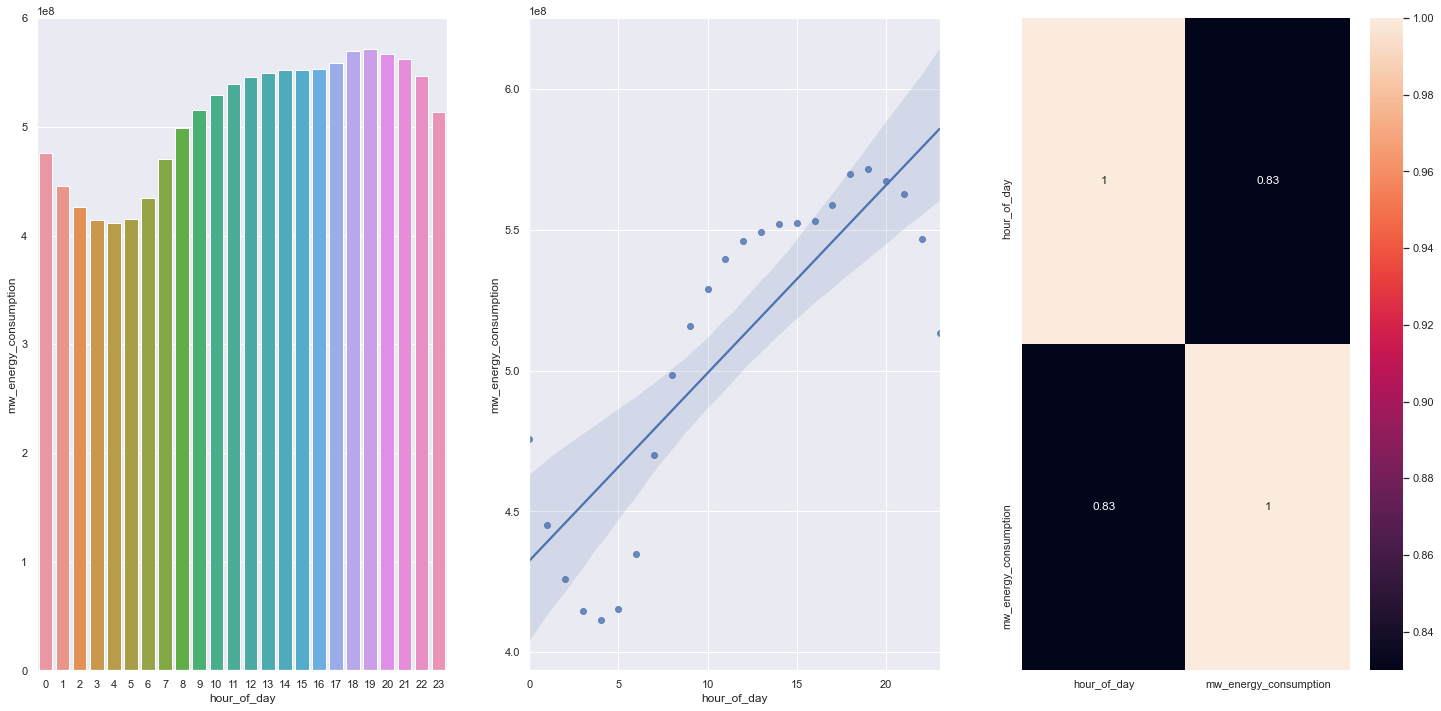

In [342]:
plt.subplot(1,3,1)
aux1 = df4[['hour_of_day', 'mw_energy_consumption']].groupby( 'hour_of_day' ).sum().reset_index()
sns.barplot( x='hour_of_day', y='mw_energy_consumption', data=aux1)

plt.subplot(1,3,2)
sns.regplot( x='hour_of_day', y='mw_energy_consumption', data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H2. Seasons with higher or lower temperatures use more energy

**TRUE** When we see the sum of all energy consumptions, we see that winter and summer, which are the seasons with the most acute temperatures, register the highest energy consumption. At the same time when we spread out over the years we observe the same behavior with rare exceptions.

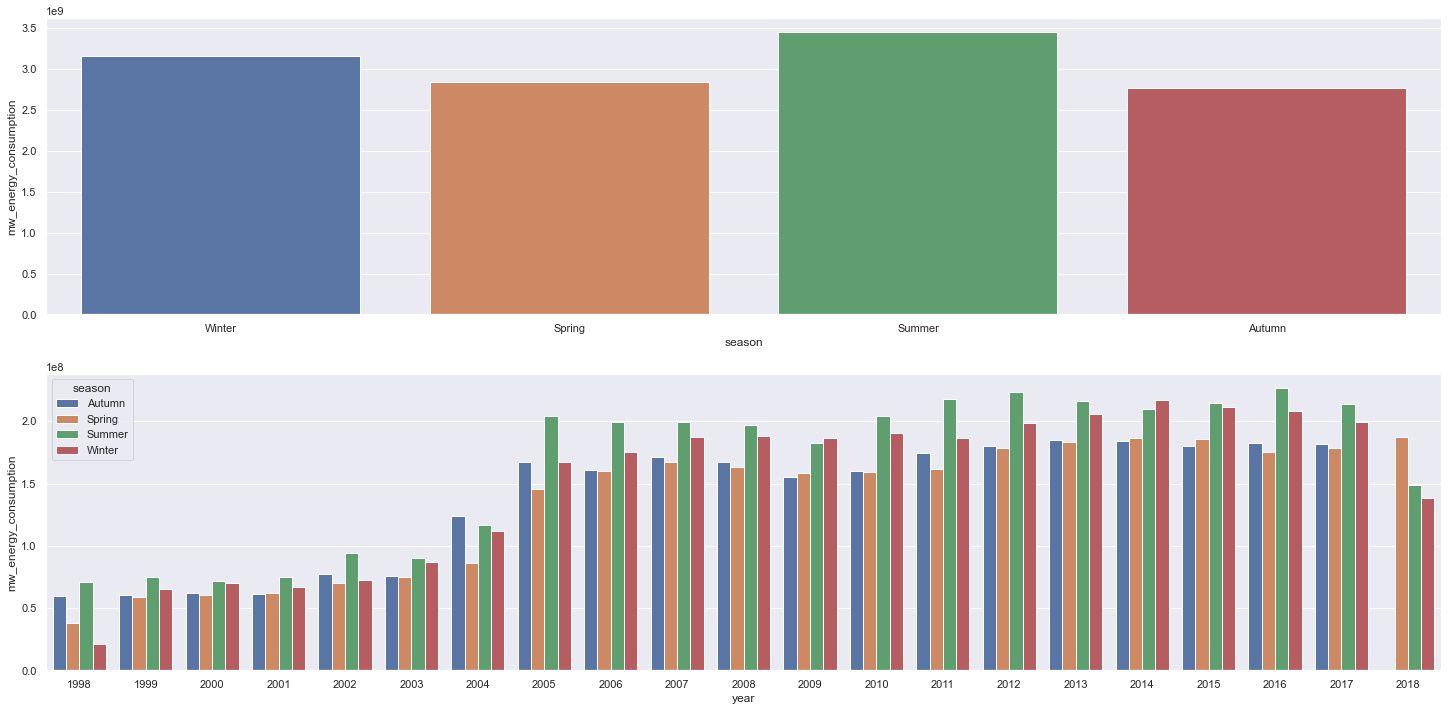

In [343]:
aux1 = df4[['season', 'mw_energy_consumption']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='mw_energy_consumption', data=aux1, order=['Winter', 'Spring', 'Summer', 'Autumn'] )

aux2 = df4[['year', 'season', 'mw_energy_consumption']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy_consumption', hue='season', data=aux2, orient=['Winter', 'Spring', 'Summer', 'Autumn'] );

### H3. Holiday periods spend more energy

**FALSE** Holiday periods spend less energy

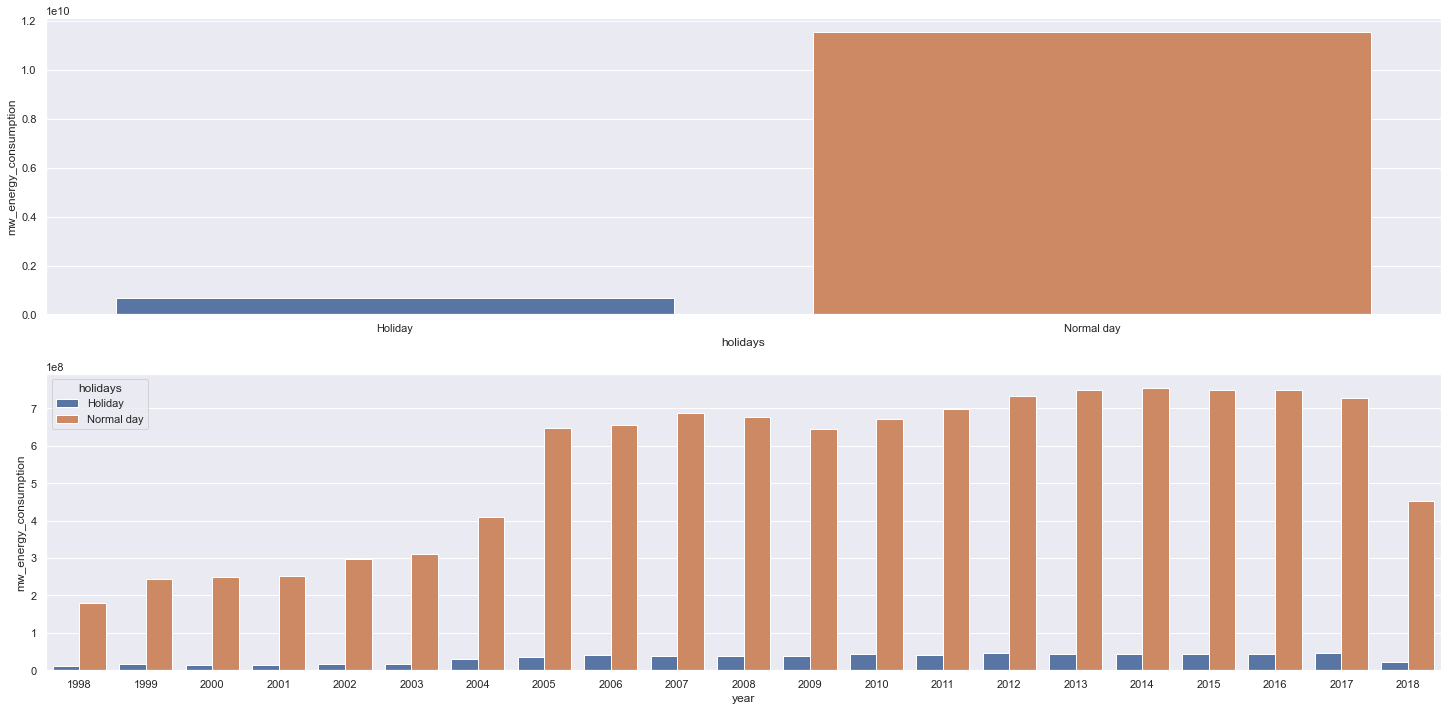

In [344]:
aux1 = df4[['holidays', 'mw_energy_consumption']].groupby( 'holidays' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='mw_energy_consumption', data=aux1 )

aux2 = df4[['year', 'holidays', 'mw_energy_consumption']].groupby( ['year', 'holidays'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy_consumption', hue='holidays', data=aux2 );

### H4. Weekends periods spend more energy

**FALSE** Weekends periods spend less energy.

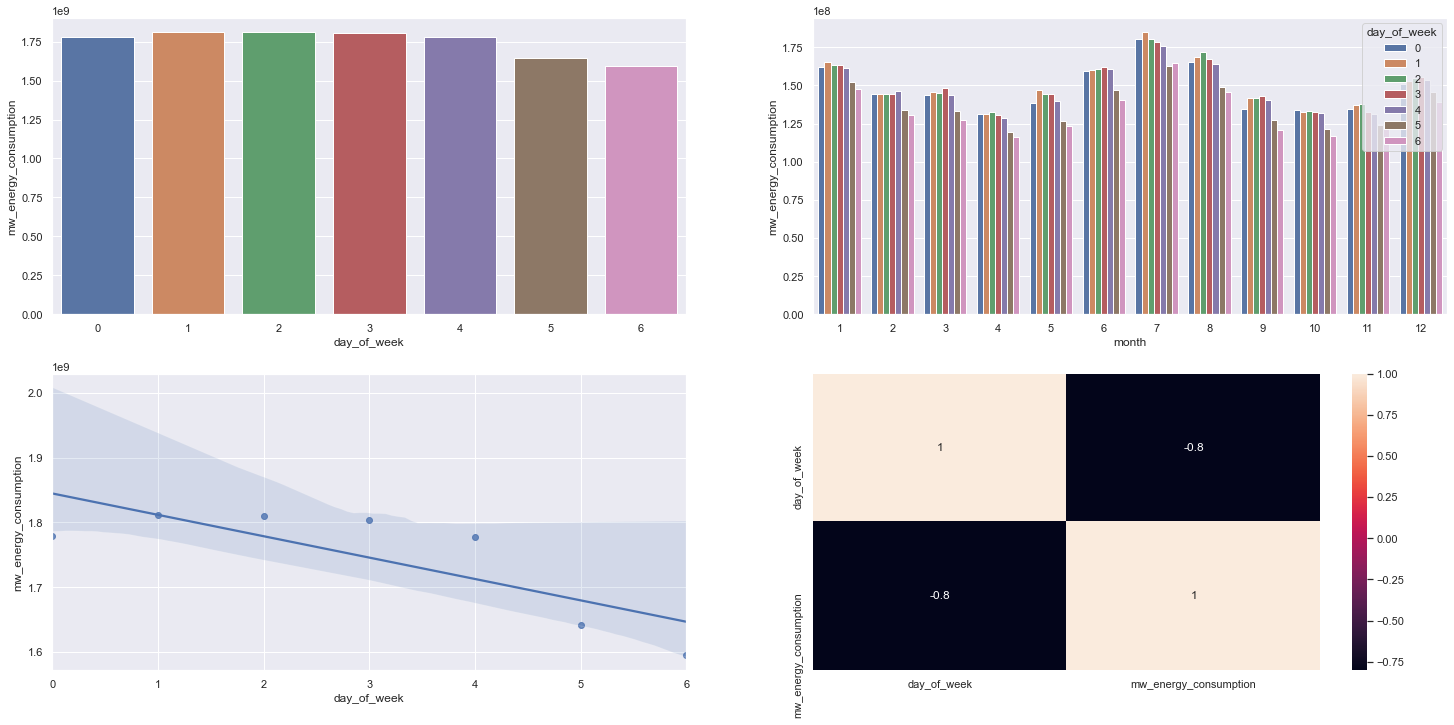

In [347]:
plt.subplot( 2, 2, 1)
aux1 = df4[['day_of_week', 'mw_energy_consumption']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x='day_of_week', y='mw_energy_consumption', data=aux1)

aux2 = df4[['month', 'day_of_week', 'mw_energy_consumption']].groupby( ['month', 'day_of_week'] ).sum().reset_index()
plt.subplot( 2, 2, 2 )
sns.barplot( x='month', y='mw_energy_consumption', hue='day_of_week', data=aux2 );

plt.subplot(2, 2, 3)
sns.regplot( x='day_of_week', y='mw_energy_consumption', data=aux1 )

plt.subplot(2, 2, 4)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# To better understand what these numbers represent in relation to the days of the week follow the legend below:
# Integer Value             Day of the week
#      0                        Monday
#      1                       Tuesday
#      2                      Wednesday
#      3                      Thursday
#      4                       Friday
#      5                      Saturday
#      6                       Sunday

### 4.2.1 Summary of Hypotheses

In [350]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'High'],
       ['H2', 'True', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'High']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            True          Medium
H3            False         Medium
H4            False         High


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

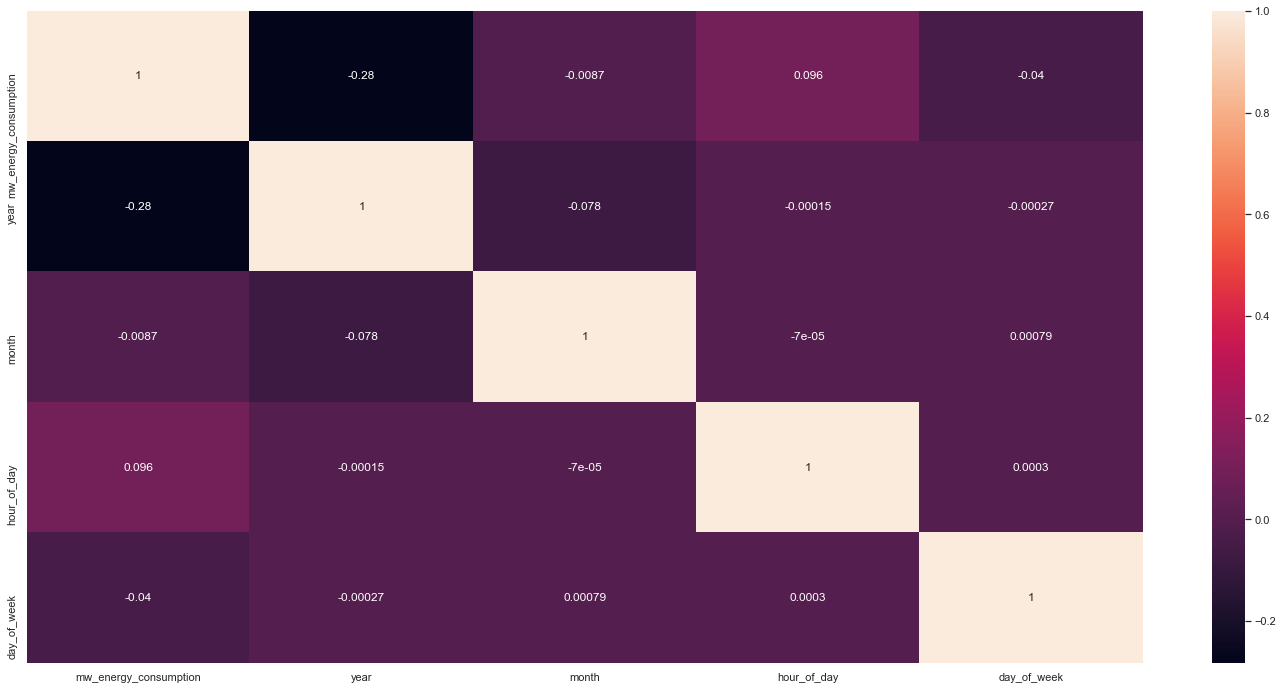

In [351]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

# As we can see, the numerical variables (year and month) that we created just to help visualize the evolution of energy consumption, have very little relevance.

### 4.3.2 Categorical Attributes

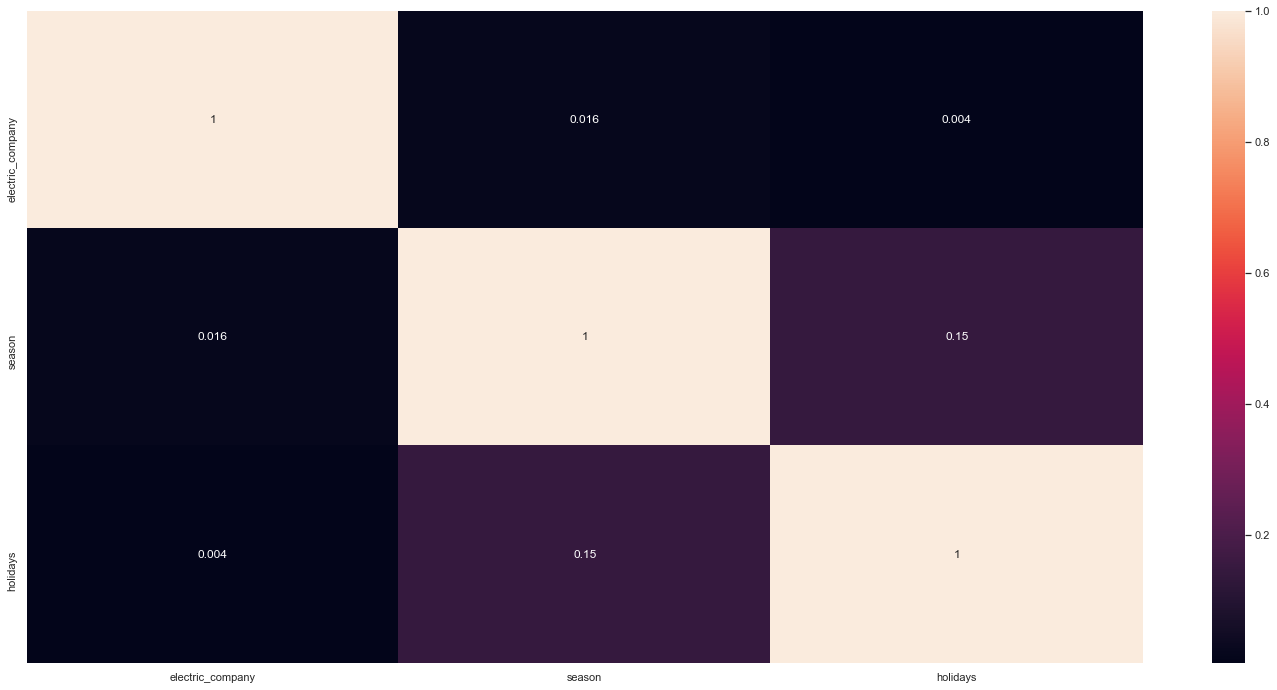

In [355]:
# When we are working with categorical variables we use another statistical technique to visualize the correlations between them. This technique is called "Cramér's V" and a function was created with its formula and it is in the section "0.1 Helper Function".
# In practice, below I will create by hand the correlation table between categorical variables.

# Only categorical data
c1 = cramer_v( cat_attributes['electric_company'], cat_attributes['electric_company'] )

# Calculate cramer V
c2 = cramer_v( cat_attributes['electric_company'], cat_attributes['season'] )
c3 = cramer_v( cat_attributes['electric_company'], cat_attributes['holidays'] )

c4 = cramer_v( cat_attributes['season'], cat_attributes['electric_company'] )
c5 = cramer_v( cat_attributes['season'], cat_attributes['season'] )
c6 = cramer_v( cat_attributes['season'], cat_attributes['holidays'] )

c7 = cramer_v( cat_attributes['holidays'], cat_attributes['electric_company'] )
c8 = cramer_v( cat_attributes['holidays'], cat_attributes['season'] )
c9 = cramer_v( cat_attributes['holidays'], cat_attributes['holidays'] )

# Final dataset
d = pd.DataFrame( {'electric_company': [c1, c2, c3],
               'season': [c4, c5, c6],
               'holidays': [c7, c8, c9]} )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )


# 5.0 STEP 05 - DATA PREPARATION

In [356]:
df5 = df4.copy()

## 5.1 Normalization

In [359]:
# We don't have any data distribution like a Gaussian

## 5.2 Rescaling

In [358]:
# We don't have any numerical variables that need scaling.
# The numerical variables in the dataset will need a nature transformation (cyclical).

## 5.3 Transformation

### 5.3.1 Encoding

In [366]:
# The only categorical variable which I will use the encoding will be the "holidays". I won't use the "season" in this moment because it's a cyclical variable and I will transform it after soon.

# As the values in the variable "holidays" do not have an important relationship between them and our final dataset will not have many columns I will use the "One Hot Encoding" technique.

df5 = pd.get_dummies( df5, prefix=['holidays'], columns=['holidays'] )

### 5.3.2 Response Variable Transformation

In [364]:
df5['mw_energy_consumption'] = np.log1p( df5['mw_energy_consumption'] )

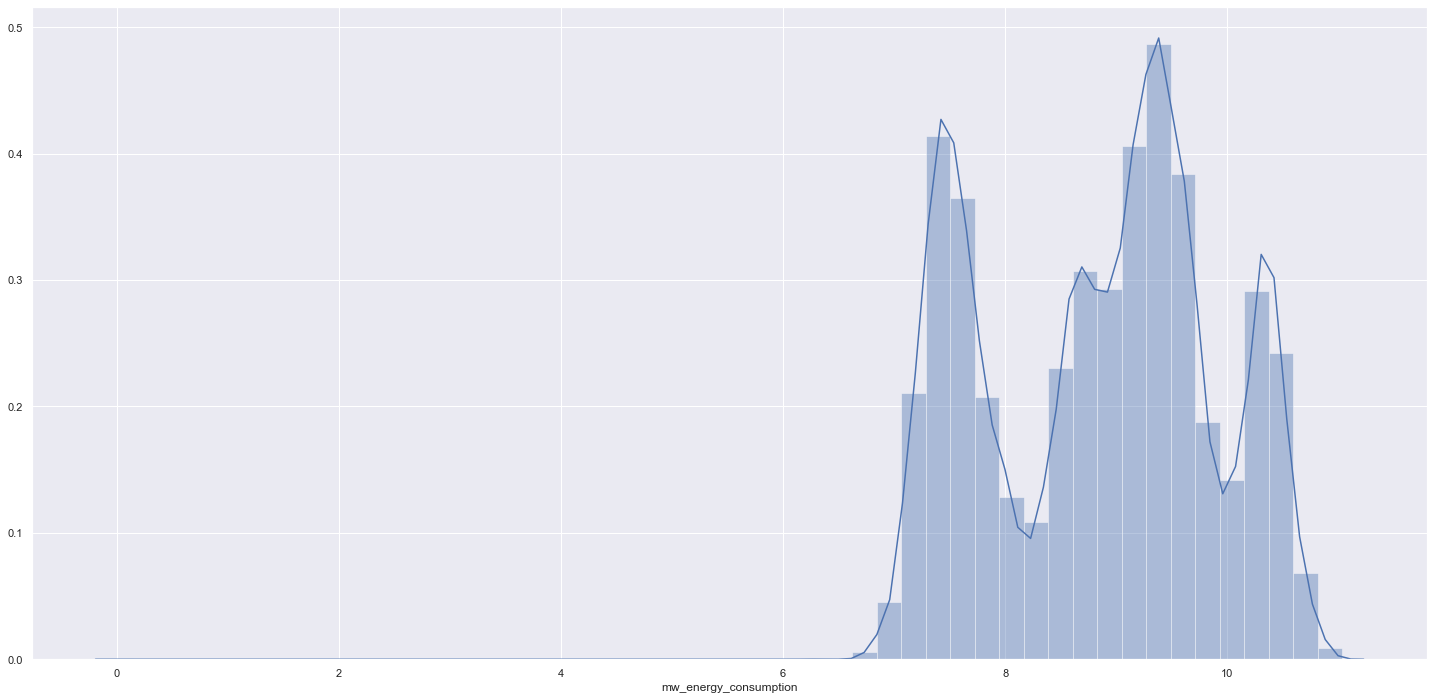

In [365]:
sns.distplot( df5['mw_energy_consumption'] )

### 5.3.1 Nature Transformation

In [363]:
# My goal here is to take the numerical data and transform its natures to cyclical.
# The cyclical variable in this dataset are "hour_of_day", "season" and "day_of_week"

# I am not going to go into mathematical details about the method used to turn numeric or categorical variables into cyclical ones, but I am going to give you an idea of what will be done.
# Cyclic behavior looks like a circle. The code will place the values within each variable in this circle and for this the concepts of sine and cosine will be used. 
# Note that at the end of the formula I divide by the amount of cyclic values present in each variable.

In [369]:
# hour_of_day
df5['hour_of_day_sin'] = df5['hour_of_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/24 ) ) )
df5['hour_of_day_cos'] = df5['hour_of_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/24 ) ) )


# season

# As the variable "season" is categorical I will first turn it into a numeric variable making its values ​​have an ordinal idea, since the seasons follow an order.
assortment_dict = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
df5['season'] = df5['season'].map( assortment_dict )

df5['season_sin'] = df5['season'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df5['season_cos'] = df5['season'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )


# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [370]:
df5.sample(5)

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week,holidays_Holiday,holidays_Normal day,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
45022,2007-08-13 10:00:00,8.754949,PJMW,2007-08-13,2007,8,10,3,0,0,1,5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,0.000000,1.000000
55660,2011-11-25 19:00:00,9.565845,AEP,2011-11-25,2011,11,19,4,4,0,1,-9.659258e-01,2.588190e-01,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
114565,2017-03-07 12:00:00,9.603868,AEP,2017-03-07,2017,3,12,2,1,0,1,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,0.781831,0.623490
8474,2011-01-12 05:00:00,9.267665,COMED,2011-01-12,2011,1,5,1,2,0,1,9.659258e-01,2.588190e-01,1.000000e+00,6.123234e-17,0.974928,-0.222521
27221,2016-06-24 06:00:00,7.075809,EKPC,2016-06-24,2016,6,6,3,4,0,1,1.000000e+00,6.123234e-17,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969


# 6.0 STEP 06 - FEATURE SELECTION

In [371]:
df6 = df5.copy()

In [372]:
df6.shape

(1090167, 17)